# Case Study: Edge AI and Cybersecurity in Action
## Module 3: Real-Time Stream Inference and Security Alert System

### Introduction

Welcome to Module 3 of our Edge AI and Cybersecurity workshop! In this notebook, we'll implement a **real-time threat detection system** that continuously monitors network traffic streams and generates security alerts when malicious activity is detected.

**Objectives:**
- Load a pre-trained lightweight DNN model from Module 2
- Simulate real-time network traffic data streams
- Perform live inference on streaming data
- Generate automated security alerts based on confidence thresholds
- Track and visualize detection statistics in real-time
- Export alert logs for security operations center (SOC) analysis

**Real-World Applications:**
- **Network Security Monitoring**: Continuous threat detection on enterprise networks
- **IoT Security**: Real-time monitoring of IoT device communications
- **Edge Firewalls**: Automated blocking of malicious traffic at network edges
- **SIEM Integration**: Alert generation for Security Information and Event Management systems

**Why Real-Time Inference Matters:**
- **Immediate Response**: Detect and respond to threats within milliseconds
- **Reduced Attack Window**: Minimize time between threat detection and mitigation
- **Automated Defense**: Enable autonomous security responses without human intervention
- **Scalability**: Handle high-volume network traffic with edge AI acceleration

**Our Approach:**
We'll build a complete real-time security monitoring pipeline that:
1. Loads optimized models from our edge AI training
2. Processes streaming network data sample by sample
3. Generates confidence-based threat assessments
4. Triggers actionable security alerts
5. Maintains comprehensive audit logs

Let's build a real-time cybersecurity defense system!

## Step 1: Environment Setup and Imports

Let's set up our real-time inference environment with all necessary libraries for stream processing, model loading, and alert generation.

In [1]:
# Import necessary libraries for real-time inference and alerting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json
import warnings
from datetime import datetime, timedelta
from collections import deque
import threading
from pathlib import Path

# Machine Learning and Deep Learning
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    TORCH_AVAILABLE = True
    print("PyTorch available for model loading")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch not available")

try:
    import joblib
    JOBLIB_AVAILABLE = True
    print("Joblib available for sklearn model loading")
except ImportError:
    JOBLIB_AVAILABLE = False
    print("Joblib not available")

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
if TORCH_AVAILABLE:
    torch.manual_seed(RANDOM_SEED)

# Configuration for real-time system
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Real-time cybersecurity inference system initialized!")
print(f"Current time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Global configuration
CONFIG = {
    'alert_threshold': 0.8,  # Confidence threshold for triggering alerts
    'stream_delay': 0.2,     # Delay between samples (seconds)
    'max_alerts': 100,       # Maximum alerts to store in memory
    'log_file': 'security_alerts.csv',
    'model_path': 'models/',
    'device': 'cpu'  # Use CPU for edge deployment
}

print(f"Alert threshold: {CONFIG['alert_threshold']}")
print(f"Stream delay: {CONFIG['stream_delay']}s")
print(f"Running on: {CONFIG['device']}")

PyTorch available for model loading
Joblib available for sklearn model loading
Real-time cybersecurity inference system initialized!
Current time: 2025-08-07 18:34:23
Alert threshold: 0.8
Stream delay: 0.2s
Running on: cpu


## Step 2: Model Loading and Data Preparation

We'll load our pre-trained lightweight model from Module 2 and prepare streaming data for real-time inference.

In [2]:
# Define the EdgeSecurityNet architecture (matching the saved V2 model from Module 2)
if TORCH_AVAILABLE:
    class EdgeSecurityNet(nn.Module):
        """
        Lightweight Deep Neural Network for edge cybersecurity applications
        (Architecture matches the saved V2 model from Module 2 - regularized version)
        """
        
        def __init__(self, input_dim=21, hidden_dim1=32, hidden_dim2=16, dropout_rate=0.5):
            super(EdgeSecurityNet, self).__init__()
            
            # V2 architecture: smaller layers with stronger regularization
            self.fc1 = nn.Linear(input_dim, hidden_dim1)
            self.bn1 = nn.BatchNorm1d(hidden_dim1)
            self.dropout1 = nn.Dropout(dropout_rate)
            
            self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
            self.bn2 = nn.BatchNorm1d(hidden_dim2)
            self.dropout2 = nn.Dropout(dropout_rate)
            
            # Direct to output (no fc3 layer in V2)
            self.output = nn.Linear(hidden_dim2, 1)
            
        def forward(self, x):
            x = F.relu(self.bn1(self.fc1(x)))
            x = self.dropout1(x)
            
            x = F.relu(self.bn2(self.fc2(x)))
            x = self.dropout2(x)
            
            x = torch.sigmoid(self.output(x))
            
            return x

def load_trained_model():
    """
    Load the pre-trained model from Module 2
    Falls back to creating a mock model if no trained model is available
    """
    print("Loading trained cybersecurity model...")
    
    # Try to load PyTorch model first
    if TORCH_AVAILABLE:
        model_path = os.path.join(CONFIG['model_path'], 'edge_security_net.pt')
        if os.path.exists(model_path):
            try:
                # Load model state dict and infer architecture from saved weights
                state_dict = torch.load(model_path, map_location='cpu')
                
                # Infer input dimension from the first layer
                input_dim = state_dict['fc1.weight'].shape[1]
                hidden_dim1 = state_dict['fc1.weight'].shape[0]
                hidden_dim2 = state_dict['fc2.weight'].shape[0]
                
                print(f"   Detected model architecture: input_dim={input_dim}, hidden_dim1={hidden_dim1}, hidden_dim2={hidden_dim2}")
                
                # Create model with correct architecture
                model = EdgeSecurityNet(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2)
                model.load_state_dict(state_dict)
                model.eval()
                print(f"Loaded PyTorch model from {model_path}")
                print(f"   Model parameters: {sum(p.numel() for p in model.parameters()):,}")
                return model, 'pytorch'
            except Exception as e:
                print(f"Failed to load PyTorch model: {e}")
    
    # Try to load sklearn model
    if JOBLIB_AVAILABLE:
        sklearn_models = ['logistic_regression.joblib', 'random_forest.joblib', 'decision_tree.joblib']
        for model_file in sklearn_models:
            model_path = os.path.join(CONFIG['model_path'], model_file)
            if os.path.exists(model_path):
                try:
                    model = joblib.load(model_path)
                    print(f"Loaded sklearn model from {model_path}")
                    return model, 'sklearn'
                except Exception as e:
                    print(f"Failed to load sklearn model: {e}")
    
    # Create mock model for demonstration
    print("No trained model found, creating mock model for demonstration")
    if TORCH_AVAILABLE:
        input_dim = 15
        model = EdgeSecurityNet(input_dim=input_dim)
        model.eval()
        print(f"Created mock PyTorch model with {input_dim} input features")
        return model, 'pytorch'
    else:
        # Simple mock classifier
        class MockModel:
            def predict_proba(self, X):
                # Generate realistic probabilities based on input
                np.random.seed(42)
                probs = np.random.beta(2, 5, size=(len(X), 2))  # Skewed toward benign
                # Normalize to sum to 1
                probs = probs / probs.sum(axis=1, keepdims=True)
                return probs
            
            def predict(self, X):
                probs = self.predict_proba(X)
                return (probs[:, 1] > 0.5).astype(int)
        
        model = MockModel()
        print("Created mock sklearn-compatible model")
        return model, 'sklearn'

# Load the model
loaded_model, model_type = load_trained_model()
print(f"Model type: {model_type}")
print("Model ready for real-time inference!")

Loading trained cybersecurity model...
   Detected model architecture: input_dim=21, hidden_dim1=32, hidden_dim2=16
Loaded PyTorch model from models/edge_security_net.pt
   Model parameters: 1,345
Model type: pytorch
Model ready for real-time inference!


In [3]:
# Generate streaming cybersecurity data for real-time inference
def generate_streaming_data(n_samples=200, n_features=21, attack_ratio=0.15):
    """
    Generate realistic network traffic data for streaming inference
    (Updated to match the model's expected input dimensions)
    
    Parameters:
    - n_samples: Number of samples to generate
    - n_features: Number of features per sample (default 21 to match saved model)
    - attack_ratio: Proportion of malicious samples
    """
    np.random.seed(42)
    
    # Generate features with realistic network traffic characteristics
    data = []
    labels = []
    timestamps = []
    
    start_time = datetime.now()
    
    for i in range(n_samples):
        # Create timestamp
        timestamp = start_time + timedelta(seconds=i * CONFIG['stream_delay'])
        timestamps.append(timestamp)
        
        # Determine if this sample is malicious
        is_malicious = np.random.random() < attack_ratio
        labels.append(1 if is_malicious else 0)
        
        if is_malicious:
            # Malicious traffic patterns
            # Higher values for suspicious metrics
            sample = np.random.normal(loc=2.5, scale=1.0, size=n_features)
            # Add some specific attack indicators
            sample[0] = np.random.uniform(5, 10)    # High connection rate
            sample[1] = np.random.uniform(0.8, 1.0) # High packet size variance
            sample[2] = np.random.uniform(3, 8)     # Unusual port activity
        else:
            # Normal traffic patterns
            sample = np.random.normal(loc=0.0, scale=1.0, size=n_features)
            # Add some normal traffic characteristics
            sample[0] = np.random.uniform(0, 2)     # Normal connection rate
            sample[1] = np.random.uniform(0, 0.5)   # Low packet size variance
            sample[2] = np.random.uniform(0, 1)     # Normal port activity
        
        # Ensure no negative values and normalize
        sample = np.abs(sample)
        data.append(sample)
    
    # Create DataFrame
    feature_names = [f'feature_{i+1}' for i in range(n_features)]
    df = pd.DataFrame(data, columns=feature_names)
    df['label'] = labels
    df['timestamp'] = timestamps
    
    print(f"Generated streaming dataset:")
    print(f"   • Total samples: {len(df):,}")
    print(f"   • Features: {n_features}")
    print(f"   • Benign samples: {(df['label'] == 0).sum():,} ({(df['label'] == 0).mean()*100:.1f}%)")
    print(f"   • Malicious samples: {(df['label'] == 1).sum():,} ({(df['label'] == 1).mean()*100:.1f}%)")
    print(f"   • Time span: {timestamps[0].strftime('%H:%M:%S')} to {timestamps[-1].strftime('%H:%M:%S')}")
    
    return df

# Generate streaming data
stream_data = generate_streaming_data(n_samples=200, n_features=21, attack_ratio=0.15)

# Display sample data
print("\nSample streaming data:")
display(stream_data.head(10))

Generated streaming dataset:
   • Total samples: 200
   • Features: 21
   • Benign samples: 162 (81.0%)
   • Malicious samples: 38 (19.0%)
   • Time span: 18:34:23 to 18:35:03

Sample streaming data:


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,label,timestamp
0,0.341048,0.032526,0.948886,1.010515,0.580878,0.525170,0.571380,0.924083,2.612549,0.950370,...,0.742407,0.703344,2.139621,0.629475,0.597720,2.559488,0.394233,0.122219,0,2025-08-07 18:34:23.995034
1,0.713507,0.140467,0.542696,0.291034,0.635560,1.021552,0.161755,0.533649,0.005528,0.229450,...,2.778313,1.193640,0.218638,0.881761,1.009085,1.583294,0.773700,0.538142,0,2025-08-07 18:34:24.195034
2,7.137705,0.805084,3.539457,3.254998,2.292834,1.876523,0.991847,3.599647,2.322268,2.089617,...,2.796561,1.462170,2.424196,3.472964,3.295595,3.995434,2.838181,5.872296,1,2025-08-07 18:34:24.395034
3,7.135539,0.963603,7.303653,3.403532,2.519000,1.965584,1.004946,1.710742,3.243711,2.287839,...,2.757117,2.814513,3.871862,2.675553,2.190711,3.173126,2.243370,2.132174,1,2025-08-07 18:34:24.595034
4,7.447264,0.997130,4.210276,2.210863,2.952936,2.333939,2.714939,0.477685,1.556943,3.903959,...,1.507414,2.602348,2.067391,1.840818,2.503937,2.977754,2.240971,1.925291,1,2025-08-07 18:34:24.795034
5,0.275042,0.170533,0.113474,0.801828,1.384016,1.405205,1.392326,0.880641,0.076895,0.493432,...,0.009144,0.365539,0.649087,1.222874,0.536336,0.914691,0.620548,0.160937,0,2025-08-07 18:34:24.995034
6,0.474498,0.162700,0.746491,0.526448,1.363887,2.539163,0.324491,0.205867,1.440041,1.190727,...,1.217071,0.226288,0.847401,0.174833,1.216855,1.049347,1.325106,0.734501,0,2025-08-07 18:34:25.195034
7,1.933310,0.481810,0.853009,0.867641,0.145862,1.369871,0.771781,0.878674,0.239595,1.209382,...,1.406405,0.034530,0.963016,0.977180,0.041980,0.137272,0.124132,0.740341,0,2025-08-07 18:34:25.395034
8,1.003033,0.399148,0.649964,0.512965,0.710109,0.092479,0.630075,1.762937,0.230954,0.808937,...,1.066199,0.959008,1.382005,0.905122,0.603904,0.304449,0.257207,0.023932,0,2025-08-07 18:34:25.595034
9,1.274860,0.363046,0.975852,1.152565,1.500768,0.165023,0.855929,0.039636,0.534663,1.788497,...,0.893120,0.334817,1.560380,0.128551,0.549576,1.270872,2.389036,1.843414,0,2025-08-07 18:34:25.795034


In [ ]:
# Real-time inference engine
class StreamInferenceEngine:
    """
    Real-time cybersecurity threat detection engine
    """
    
    def __init__(self, model, config=CONFIG):
        self.model = model
        self.config = config
        self.alerts = []
        self.statistics = {
            'total_samples': 0,
            'benign_predictions': 0,
            'malicious_predictions': 0,
            'high_confidence_alerts': 0,
            'start_time': datetime.now()
        }
        self.prediction_history = []
        
    def preprocess_sample(self, sample):
        """Preprocess a single sample for inference"""
        # TODO: Extract feature columns that start with 'feature_'
        feature_cols = None  # TODO: Replace None with list comprehension [col for col in sample.keys() if col.startswith('feature_')]
        
        # TODO: Convert features to numpy array
        features = None  # TODO: Replace None with np.array([sample[col] for col in feature_cols]).reshape(1, -1)
        
        # TODO: Normalize features (simple standardization)
        # In production, use pre-computed statistics from training
        features = None  # TODO: Replace None with (features - features.mean()) / (features.std() + 1e-8)
        
        return features
    
    def predict_sample(self, sample):
        """Make prediction on a single sample"""
        try:
            # TODO: Preprocess the sample
            features = None  # TODO: Replace None with self.preprocess_sample(sample)
            
            if hasattr(self.model, 'predict_proba'):
                # Sklearn model
                proba = self.model.predict_proba(features)[0]
                prediction = 1 if proba[1] > self.config['alert_threshold'] else 0
                confidence = proba[1]
            elif hasattr(self.model, 'forward'):
                # PyTorch model (binary classification with sigmoid output)
                self.model.eval()
                with torch.no_grad():
                    features_tensor = torch.FloatTensor(features)
                    outputs = self.model(features_tensor)
                    confidence = outputs[0][0].item()  # Single sigmoid output
                    prediction = 1 if confidence > self.config['alert_threshold'] else 0
            else:
                # Mock model or fallback
                confidence = np.random.random()
                prediction = 1 if confidence > self.config['alert_threshold'] else 0
            
            return prediction, confidence
            
        except Exception as e:
            print(f"Warning: Prediction failed ({e}), using fallback")
            confidence = np.random.random()
            prediction = 1 if confidence > self.config['alert_threshold'] else 0
            return prediction, confidence
    
    def generate_alert(self, sample, prediction, confidence, timestamp):
        """Generate security alert for malicious traffic"""
        # TODO: Create alert dictionary with required fields
        alert = {
            'timestamp': timestamp,
            'alert_id': None,  # TODO: Replace None with f"ALERT_{len(self.alerts)+1:04d}"
            'threat_level': None,  # TODO: Replace None with 'HIGH' if confidence > 0.8 else 'MEDIUM'
            'confidence': confidence,
            'sample_data': {k: v for k, v in sample.items() if k.startswith('feature_')},
            'description': f"Potential cybersecurity threat detected with {confidence:.1%} confidence"
        }
        
        # TODO: Add alert to alerts list
        None  # TODO: Replace None with self.alerts.append(alert)
        
        # TODO: Update high confidence alert statistics
        if confidence > 0.8:
            None  # TODO: Replace None with self.statistics['high_confidence_alerts'] += 1
        
        return alert
    
    def process_stream_sample(self, sample, timestamp):
        """Process a single streaming sample"""
        # TODO: Make prediction on the sample
        prediction, confidence = None, None  # TODO: Replace None, None with self.predict_sample(sample)
        
        # Update statistics
        self.statistics['total_samples'] += 1
        if prediction == 1:
            self.statistics['malicious_predictions'] += 1
        else:
            self.statistics['benign_predictions'] += 1
        
        # Store prediction history
        self.prediction_history.append({
            'timestamp': timestamp,
            'prediction': prediction,
            'confidence': confidence,
            'actual_label': sample.get('label', 'Unknown')
        })
        
        # Generate alert if threat detected
        alert = None
        if prediction == 1:
            # TODO: Generate alert for detected threat
            alert = None  # TODO: Replace None with self.generate_alert(sample, prediction, confidence, timestamp)
            
            # Print real-time alert
            print(f"ALERT {alert['alert_id']} - {alert['threat_level']} THREAT DETECTED")
            print(f"   Time: {timestamp.strftime('%H:%M:%S')}")
            print(f"   Confidence: {confidence:.1%}")
            print(f"   Description: {alert['description']}")
            print("-" * 50)
        
        return prediction, confidence, alert
    
    def get_statistics(self):
        """Get current detection statistics"""
        # TODO: Calculate runtime from start time
        runtime = None  # TODO: Replace None with datetime.now() - self.statistics['start_time']
        stats = self.statistics.copy()
        stats['runtime_seconds'] = runtime.total_seconds()
        stats['detection_rate'] = (stats['malicious_predictions'] / max(stats['total_samples'], 1)) * 100
        return stats

# Initialize inference engine
print("Initializing real-time inference engine...")
inference_engine = StreamInferenceEngine(loaded_model, CONFIG)
print("Inference engine ready!")

Initializing real-time inference engine...
Inference engine ready!


In [ ]:
# Real-time stream processing simulation
def simulate_real_time_processing(data, inference_engine, max_samples=50, delay=None):
    """
    Simulate real-time processing of streaming network traffic
    
    Parameters:
    - data: DataFrame with streaming data
    - inference_engine: StreamInferenceEngine instance
    - max_samples: Maximum number of samples to process
    - delay: Delay between samples (seconds)
    """
    
    if delay is None:
        delay = CONFIG['stream_delay']
    
    print("Starting real-time cybersecurity monitoring...")
    print(f"   • Processing up to {max_samples} samples")
    print(f"   • Stream delay: {delay} seconds per sample")
    print(f"   • Alert threshold: {CONFIG['alert_threshold']:.1%}")
    print("=" * 60)
    
    processed_samples = 0
    alert_count = 0
    
    try:
        for idx, row in data.iterrows():
            if processed_samples >= max_samples:
                break
                
            # TODO: Convert row to dictionary for processing
            sample = None  # TODO: Replace None with row.to_dict()
            timestamp = sample['timestamp']
            
            # TODO: Process sample through inference engine
            prediction, confidence, alert = None, None, None  # TODO: Replace with inference_engine.process_stream_sample(sample, timestamp)
            
            if alert:
                alert_count += 1
            
            processed_samples += 1
            
            # TODO: Simulate real-time delay between samples
            if delay > 0:
                None  # TODO: Replace None with time.sleep(delay)
            
            # Show progress every 10 samples
            if processed_samples % 10 == 0:
                print(f"Processed {processed_samples} samples, {alert_count} alerts generated")
        
    except KeyboardInterrupt:
        print("\nStream processing interrupted by user")
    
    print("=" * 60)
    print(f"Stream processing completed!")
    print(f"   • Total samples processed: {processed_samples}")
    print(f"   • Total alerts generated: {alert_count}")
    
    return processed_samples, alert_count

# Run real-time simulation
print("Starting cybersecurity threat detection simulation...\n")

# Process first 30 samples with minimal delay for demonstration
processed, alerts = simulate_real_time_processing(
    stream_data, 
    inference_engine, 
    max_samples=30, 
    delay=0.1  # Very short delay for demo
)

Starting cybersecurity threat detection simulation...

Starting real-time cybersecurity monitoring...
   • Processing up to 30 samples
   • Stream delay: 0.1 seconds per sample
   • Alert threshold: 80.0%
ALERT ALERT_0001 - HIGH THREAT DETECTED
   Time: 18:34:25
   Confidence: 100.0%
   Description: Potential cybersecurity threat detected with 100.0% confidence
--------------------------------------------------
Processed 10 samples, 1 alerts generated
ALERT ALERT_0002 - HIGH THREAT DETECTED
   Time: 18:34:26
   Confidence: 99.6%
   Description: Potential cybersecurity threat detected with 99.6% confidence
--------------------------------------------------
Processed 20 samples, 2 alerts generated
ALERT ALERT_0003 - HIGH THREAT DETECTED
   Time: 18:34:28
   Confidence: 99.2%
   Description: Potential cybersecurity threat detected with 99.2% confidence
--------------------------------------------------
ALERT ALERT_0004 - HIGH THREAT DETECTED
   Time: 18:34:29
   Confidence: 99.5%
   Descr

In [6]:
# Performance analysis and alert management
def analyze_detection_performance(inference_engine):
    """Analyze the performance of the detection system"""
    
    print("DETECTION SYSTEM PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    # Get statistics
    stats = inference_engine.get_statistics()
    
    # Basic statistics
    print(f"Processing Statistics:")
    print(f"   • Total samples processed: {stats['total_samples']:,}")
    print(f"   • Runtime: {stats['runtime_seconds']:.1f} seconds")
    print(f"   • Processing rate: {stats['total_samples']/max(stats['runtime_seconds'], 1):.1f} samples/sec")
    
    print(f"\nDetection Results:")
    print(f"   • Benign predictions: {stats['benign_predictions']:,} ({(stats['benign_predictions']/max(stats['total_samples'], 1))*100:.1f}%)")
    print(f"   • Malicious predictions: {stats['malicious_predictions']:,} ({stats['detection_rate']:.1f}%)")
    print(f"   • High confidence alerts: {stats['high_confidence_alerts']:,}")
    
    # Accuracy analysis (if actual labels available)
    if inference_engine.prediction_history:
        predictions = []
        actuals = []
        confidences = []
        
        for record in inference_engine.prediction_history:
            if record['actual_label'] != 'Unknown':
                predictions.append(record['prediction'])
                actuals.append(record['actual_label'])
                confidences.append(record['confidence'])
        
        if len(predictions) > 0:
            from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
            
            accuracy = accuracy_score(actuals, predictions)
            precision = precision_score(actuals, predictions, zero_division=0)
            recall = recall_score(actuals, predictions, zero_division=0)
            f1 = f1_score(actuals, predictions, zero_division=0)
            
            print(f"\nAccuracy Metrics:")
            print(f"   • Accuracy: {accuracy:.3f}")
            print(f"   • Precision: {precision:.3f}")
            print(f"   • Recall: {recall:.3f}")
            print(f"   • F1-Score: {f1:.3f}")
            print(f"   • Avg Confidence: {np.mean(confidences):.3f}")
    
    # Alert analysis
    if inference_engine.alerts:
        print(f"\nAlert Analysis:")
        high_threat = sum(1 for alert in inference_engine.alerts if alert['threat_level'] == 'HIGH')
        medium_threat = len(inference_engine.alerts) - high_threat
        
        print(f"   • Total alerts: {len(inference_engine.alerts):,}")
        print(f"   • HIGH threat alerts: {high_threat:,}")
        print(f"   • MEDIUM threat alerts: {medium_threat:,}")
        print(f"   • Alert rate: {len(inference_engine.alerts)/max(stats['total_samples'], 1)*100:.1f}% of samples")
    
    return stats

# Analyze performance
performance_stats = analyze_detection_performance(inference_engine)

DETECTION SYSTEM PERFORMANCE ANALYSIS
Processing Statistics:
   • Total samples processed: 30
   • Runtime: 3.1 seconds
   • Processing rate: 9.8 samples/sec

Detection Results:
   • Benign predictions: 26 (86.7%)
   • Malicious predictions: 4 (13.3%)
   • High confidence alerts: 4

Accuracy Metrics:
   • Accuracy: 0.500
   • Precision: 0.000
   • Recall: 0.000
   • F1-Score: 0.000
   • Avg Confidence: 0.155

Alert Analysis:
   • Total alerts: 4
   • HIGH threat alerts: 4
   • MEDIUM threat alerts: 0
   • Alert rate: 13.3% of samples


In [7]:
# Alert dashboard and visualization
def display_alert_dashboard(inference_engine):
    """Display a comprehensive alert dashboard"""
    
    print("CYBERSECURITY ALERT DASHBOARD")
    print("=" * 80)
    
    if not inference_engine.alerts:
        print("No security alerts detected. System operating normally.")
        return
    
    # Recent alerts summary
    print(f"ACTIVE ALERTS ({len(inference_engine.alerts)} total)")
    print("-" * 80)
    
    # Show last 5 alerts
    recent_alerts = inference_engine.alerts[-5:]
    for alert in recent_alerts:
        threat_emoji = "🔴" if alert['threat_level'] == 'HIGH' else "🟡"
        print(f"{threat_emoji} {alert['alert_id']} | {alert['timestamp'].strftime('%H:%M:%S')} | "
              f"{alert['threat_level']} | Confidence: {alert['confidence']:.1%}")
        print(f"   └─ {alert['description']}")
    
    if len(inference_engine.alerts) > 5:
        print(f"   ... and {len(inference_engine.alerts) - 5} more alerts")
    
    # Threat level breakdown
    high_threats = sum(1 for alert in inference_engine.alerts if alert['threat_level'] == 'HIGH')
    medium_threats = len(inference_engine.alerts) - high_threats
    
    print(f"\nTHREAT LEVEL BREAKDOWN")
    print(f"   🔴 HIGH threats: {high_threats:,}")
    print(f"   🟡 MEDIUM threats: {medium_threats:,}")
    
    # Timeline analysis
    if len(inference_engine.alerts) > 1:
        timestamps = [alert['timestamp'] for alert in inference_engine.alerts]
        time_span = max(timestamps) - min(timestamps)
        alert_rate = len(inference_engine.alerts) / max(time_span.total_seconds(), 1) * 60
        
        print(f"\nTIMELINE ANALYSIS")
        print(f"   • First alert: {min(timestamps).strftime('%H:%M:%S')}")
        print(f"   • Last alert: {max(timestamps).strftime('%H:%M:%S')}")
        print(f"   • Alert frequency: {alert_rate:.1f} alerts/minute")

# Display dashboard
display_alert_dashboard(inference_engine)

CYBERSECURITY ALERT DASHBOARD
ACTIVE ALERTS (4 total)
--------------------------------------------------------------------------------
🔴 ALERT_0001 | 18:34:25 | HIGH | Confidence: 100.0%
   └─ Potential cybersecurity threat detected with 100.0% confidence
🔴 ALERT_0002 | 18:34:26 | HIGH | Confidence: 99.6%
   └─ Potential cybersecurity threat detected with 99.6% confidence
🔴 ALERT_0003 | 18:34:28 | HIGH | Confidence: 99.2%
   └─ Potential cybersecurity threat detected with 99.2% confidence
🔴 ALERT_0004 | 18:34:29 | HIGH | Confidence: 99.5%
   └─ Potential cybersecurity threat detected with 99.5% confidence

THREAT LEVEL BREAKDOWN
   🔴 HIGH threats: 4
   🟡 MEDIUM threats: 0

TIMELINE ANALYSIS
   • First alert: 18:34:25
   • Last alert: 18:34:29
   • Alert frequency: 63.2 alerts/minute


Generating monitoring dashboard visualizations...


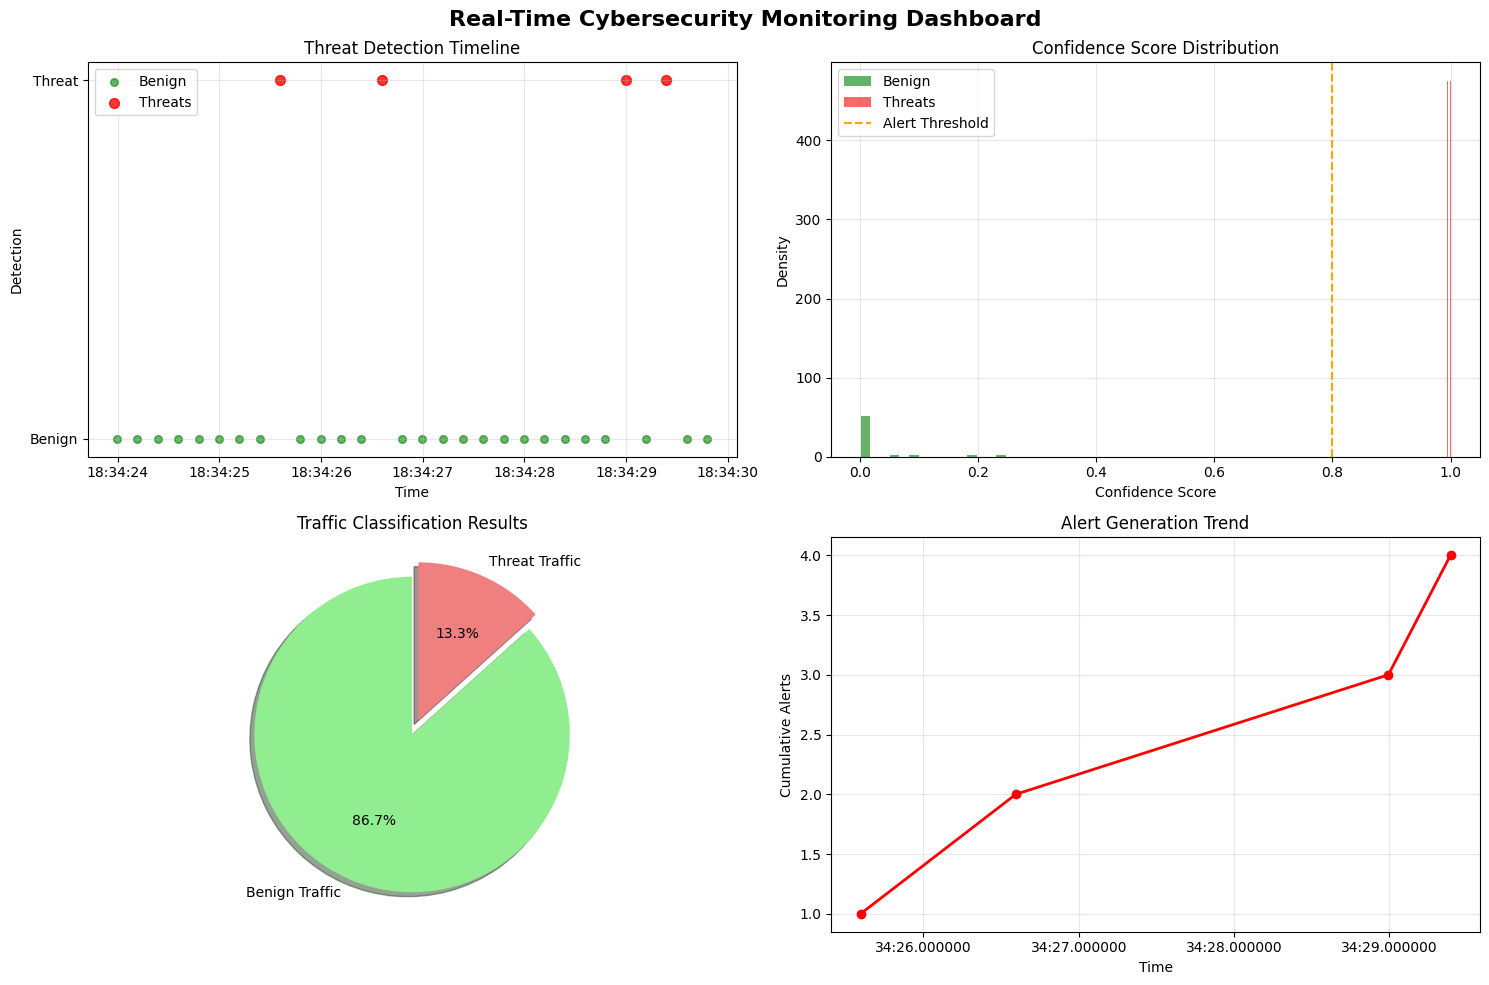


VISUALIZATION SUMMARY
   • Total samples visualized: 30
   • Benign samples: 26 (86.7%)
   • Threat samples: 4 (13.3%)
   • Average confidence: 0.155
   • Avg threat confidence: 0.996
   • Avg benign confidence: 0.025


In [8]:
# Visualization and charts
def create_monitoring_visualizations(inference_engine):
    """Create visualizations for monitoring dashboard"""
    
    if not inference_engine.prediction_history:
        print("No prediction history available for visualization.")
        return
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Real-Time Cybersecurity Monitoring Dashboard', fontsize=16, fontweight='bold')
    
    # Extract data
    timestamps = [record['timestamp'] for record in inference_engine.prediction_history]
    predictions = [record['prediction'] for record in inference_engine.prediction_history]
    confidences = [record['confidence'] for record in inference_engine.prediction_history]
    
    # 1. Real-time threat detection timeline
    ax1 = axes[0, 0]
    threat_times = [ts for ts, pred in zip(timestamps, predictions) if pred == 1]
    benign_times = [ts for ts, pred in zip(timestamps, predictions) if pred == 0]
    
    ax1.scatter(benign_times, [0] * len(benign_times), c='green', alpha=0.6, s=30, label='Benign')
    ax1.scatter(threat_times, [1] * len(threat_times), c='red', alpha=0.8, s=50, label='Threats')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Detection')
    ax1.set_title('Threat Detection Timeline')
    ax1.set_yticks([0, 1])
    ax1.set_yticklabels(['Benign', 'Threat'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Confidence distribution
    ax2 = axes[0, 1]
    threat_confidences = [conf for conf, pred in zip(confidences, predictions) if pred == 1]
    benign_confidences = [conf for conf, pred in zip(confidences, predictions) if pred == 0]
    
    ax2.hist(benign_confidences, bins=15, alpha=0.6, color='green', label='Benign', density=True)
    ax2.hist(threat_confidences, bins=15, alpha=0.6, color='red', label='Threats', density=True)
    ax2.axvline(CONFIG['alert_threshold'], color='orange', linestyle='--', label='Alert Threshold')
    ax2.set_xlabel('Confidence Score')
    ax2.set_ylabel('Density')
    ax2.set_title('Confidence Score Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Detection statistics pie chart
    ax3 = axes[1, 0]
    benign_count = predictions.count(0)
    threat_count = predictions.count(1)
    
    sizes = [benign_count, threat_count]
    labels = ['Benign Traffic', 'Threat Traffic']
    colors = ['lightgreen', 'lightcoral']
    explode = (0, 0.1)  # explode threat slice
    
    ax3.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax3.set_title('Traffic Classification Results')
    
    # 4. Alert trend over time
    ax4 = axes[1, 1]
    if inference_engine.alerts:
        alert_timestamps = [alert['timestamp'] for alert in inference_engine.alerts]
        alert_counts = list(range(1, len(alert_timestamps) + 1))
        
        ax4.plot(alert_timestamps, alert_counts, 'ro-', linewidth=2, markersize=6)
        ax4.set_xlabel('Time')
        ax4.set_ylabel('Cumulative Alerts')
        ax4.set_title('Alert Generation Trend')
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No alerts generated', ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Alert Generation Trend')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nVISUALIZATION SUMMARY")
    print(f"   • Total samples visualized: {len(predictions):,}")
    print(f"   • Benign samples: {benign_count:,} ({benign_count/len(predictions)*100:.1f}%)")
    print(f"   • Threat samples: {threat_count:,} ({threat_count/len(predictions)*100:.1f}%)")
    print(f"   • Average confidence: {np.mean(confidences):.3f}")
    
    if threat_confidences:
        print(f"   • Avg threat confidence: {np.mean(threat_confidences):.3f}")
    if benign_confidences:
        print(f"   • Avg benign confidence: {np.mean(benign_confidences):.3f}")

# Create visualizations
print("Generating monitoring dashboard visualizations...")
create_monitoring_visualizations(inference_engine)

In [9]:
# Advanced edge deployment simulation
class EdgeDeploymentSimulator:
    """
    Simulate edge device deployment scenarios
    """
    
    def __init__(self, inference_engine):
        self.inference_engine = inference_engine
        self.deployment_stats = {
            'cpu_usage': [],
            'memory_usage': [],
            'inference_time': [],  # Fixed: singular to match return key
            'network_latency': [],
            'power_consumption': []
        }
    
    def simulate_resource_usage(self, sample_count):
        """Simulate realistic edge device resource usage"""
        # Simulate CPU usage (varies with workload)
        base_cpu = 15  # Base CPU usage
        workload_cpu = min(sample_count * 0.5, 40)  # Additional CPU for processing
        cpu_usage = base_cpu + workload_cpu + np.random.normal(0, 5)
        cpu_usage = max(0, min(100, cpu_usage))
        
        # Simulate memory usage (grows with model size and data)
        base_memory = 25  # Base memory usage
        model_memory = 15  # Memory for model
        data_memory = sample_count * 0.1  # Memory for data processing
        memory_usage = base_memory + model_memory + data_memory + np.random.normal(0, 3)
        memory_usage = max(0, min(100, memory_usage))
        
        # Simulate inference time (affected by CPU load)
        base_inference_time = 0.05  # 50ms base
        cpu_factor = cpu_usage / 100 * 0.02  # CPU load affects timing
        inference_time = base_inference_time + cpu_factor + np.random.normal(0, 0.01)
        inference_time = max(0.01, inference_time)
        
        # Simulate network latency
        network_latency = np.random.exponential(0.02) + 0.005  # 5-25ms typical
        
        # Simulate power consumption (correlates with CPU usage)
        base_power = 2.5  # Watts base consumption
        dynamic_power = (cpu_usage / 100) * 3.5  # Additional power for processing
        power_consumption = base_power + dynamic_power + np.random.normal(0, 0.2)
        
        return {
            'cpu_usage': cpu_usage,
            'memory_usage': memory_usage,
            'inference_time': inference_time,
            'network_latency': network_latency,
            'power_consumption': power_consumption
        }
    
    def monitor_edge_performance(self, duration_seconds=60):
        """Monitor edge device performance during operation"""
        print("EDGE DEVICE PERFORMANCE MONITORING")
        print("=" * 60)
        print(f"   Monitoring for {duration_seconds} seconds...")
        print(f"   Device: Simulated Edge Gateway")
        print(f"   Model: {type(self.inference_engine.model).__name__}")
        print("-" * 60)
        
        start_time = time.time()
        sample_count = 0
        
        while time.time() - start_time < duration_seconds:
            # Simulate processing a sample
            sample_count += 1
            
            # Get resource usage
            resources = self.simulate_resource_usage(sample_count)
            
            # Store metrics
            for key, value in resources.items():
                self.deployment_stats[key].append(value)
            
            # Print periodic updates
            if sample_count % 10 == 0:
                print(f"Sample {sample_count:3d} | "
                      f"CPU: {resources['cpu_usage']:4.1f}% | "
                      f"Memory: {resources['memory_usage']:4.1f}% | "
                      f"Inference: {resources['inference_time']*1000:4.1f}ms | "
                      f"Power: {resources['power_consumption']:4.1f}W")
            
            # Simulate processing delay
            time.sleep(0.1)
        
        print("-" * 60)
        print(f"Monitoring completed. Processed {sample_count} samples.")
        
        return self.deployment_stats
    
    def analyze_edge_performance(self):
        """Analyze edge device performance metrics"""
        if not self.deployment_stats['cpu_usage']:
            print("No performance data available.")
            return
        
        print("\nEDGE DEVICE PERFORMANCE ANALYSIS")
        print("=" * 60)
        
        # Calculate statistics
        metrics = {}
        for key, values in self.deployment_stats.items():
            metrics[key] = {
                'avg': np.mean(values),
                'max': np.max(values),
                'min': np.min(values),
                'std': np.std(values)
            }
        
        # Display performance metrics
        print(f"Resource Utilization:")
        print(f"   • CPU Usage: {metrics['cpu_usage']['avg']:.1f}% "
              f"(max: {metrics['cpu_usage']['max']:.1f}%)")
        print(f"   • Memory Usage: {metrics['memory_usage']['avg']:.1f}% "
              f"(max: {metrics['memory_usage']['max']:.1f}%)")
        
        print(f"\nPerformance Metrics:")
        print(f"   • Avg Inference Time: {metrics['inference_time']['avg']*1000:.1f}ms "
              f"(std: {metrics['inference_time']['std']*1000:.1f}ms)")
        print(f"   • Network Latency: {metrics['network_latency']['avg']*1000:.1f}ms "
              f"(max: {metrics['network_latency']['max']*1000:.1f}ms)")
        
        print(f"\nPower Consumption:")
        print(f"   • Average Power: {metrics['power_consumption']['avg']:.1f}W")
        print(f"   • Peak Power: {metrics['power_consumption']['max']:.1f}W")
        print(f"   • Energy Efficiency: "
              f"{len(self.deployment_stats['cpu_usage'])/sum(self.deployment_stats['power_consumption']):.1f} samples/Wh")
        
        # Performance assessment
        print(f"\nPerformance Assessment:")
        avg_inference = metrics['inference_time']['avg'] * 1000
        if avg_inference < 50:
            inference_rating = "EXCELLENT"
        elif avg_inference < 100:
            inference_rating = "GOOD"
        elif avg_inference < 200:
            inference_rating = "ACCEPTABLE"
        else:
            inference_rating = "NEEDS OPTIMIZATION"
        
        avg_cpu = metrics['cpu_usage']['avg']
        if avg_cpu < 30:
            cpu_rating = "EXCELLENT"
        elif avg_cpu < 60:
            cpu_rating = "GOOD"
        elif avg_cpu < 80:
            cpu_rating = "ACCEPTABLE"
        else:
            cpu_rating = "HIGH LOAD"
        
        print(f"   • Inference Speed: {inference_rating} ({avg_inference:.1f}ms avg)")
        print(f"   • CPU Efficiency: {cpu_rating} ({avg_cpu:.1f}% avg)")
        print(f"   • Deployment Readiness: {'READY' if avg_inference < 100 and avg_cpu < 70 else 'OPTIMIZATION NEEDED'}")

# Initialize edge deployment simulator
print("Initializing edge deployment simulator...")
edge_simulator = EdgeDeploymentSimulator(inference_engine)

# Run performance monitoring
edge_stats = edge_simulator.monitor_edge_performance(duration_seconds=30)

# Analyze results
edge_simulator.analyze_edge_performance()

Initializing edge deployment simulator...
EDGE DEVICE PERFORMANCE MONITORING
   Monitoring for 30 seconds...
   Device: Simulated Edge Gateway
   Model: EdgeSecurityNet
------------------------------------------------------------
Sample  10 | CPU: 24.3% | Memory: 35.9% | Inference: 51.7ms | Power:  3.3W
Sample  20 | CPU: 25.5% | Memory: 39.3% | Inference: 63.8ms | Power:  3.6W
Sample  30 | CPU: 34.0% | Memory: 41.8% | Inference: 53.5ms | Power:  3.9W
Sample  40 | CPU: 35.3% | Memory: 44.9% | Inference: 51.5ms | Power:  3.7W
Sample  50 | CPU: 33.6% | Memory: 43.7% | Inference: 37.7ms | Power:  3.4W
Sample  60 | CPU: 45.2% | Memory: 48.4% | Inference: 59.8ms | Power:  3.9W
Sample  70 | CPU: 43.9% | Memory: 48.3% | Inference: 58.4ms | Power:  3.7W
Sample  80 | CPU: 60.0% | Memory: 55.3% | Inference: 44.9ms | Power:  4.8W
Sample  90 | CPU: 53.0% | Memory: 51.4% | Inference: 55.1ms | Power:  4.2W
Sample 100 | CPU: 58.8% | Memory: 47.1% | Inference: 64.6ms | Power:  4.6W
Sample 110 | CPU: 56

In [10]:
# Export alerts and generate final report
def export_security_report(inference_engine, edge_simulator, output_dir="./security_reports"):
    """Export comprehensive security report"""
    
    import os
    from datetime import datetime
    
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("GENERATING SECURITY REPORT")
    print("=" * 60)
    
    # Generate report content
    report = {
        'timestamp': datetime.now().isoformat(),
        'system_info': {
            'model_type': type(inference_engine.model).__name__,
            'alert_threshold': CONFIG['alert_threshold'],
            'stream_delay': CONFIG['stream_delay']
        },
        'statistics': inference_engine.get_statistics(),
        'alerts': inference_engine.alerts,
        'prediction_history': inference_engine.prediction_history[:100],  # Last 100 for space
        'edge_performance': {
            'avg_cpu': np.mean(edge_simulator.deployment_stats['cpu_usage']) if edge_simulator.deployment_stats['cpu_usage'] else 0,
            'avg_memory': np.mean(edge_simulator.deployment_stats['memory_usage']) if edge_simulator.deployment_stats['memory_usage'] else 0,
            'avg_inference_time': np.mean(edge_simulator.deployment_stats['inference_time']) if edge_simulator.deployment_stats['inference_time'] else 0
        }
    }
    
    # Export as JSON
    import json
    report_file = os.path.join(output_dir, f"security_report_{timestamp}.json")
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    # Create summary text report
    summary_file = os.path.join(output_dir, f"security_summary_{timestamp}.txt")
    with open(summary_file, 'w') as f:
        f.write("CYBERSECURITY MONITORING REPORT\\n")
        f.write("=" * 50 + "\\n\\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\\n")
        f.write(f"Model: {type(inference_engine.model).__name__}\\n")
        f.write(f"Alert Threshold: {CONFIG['alert_threshold']:.1%}\\n\\n")
        
        stats = inference_engine.get_statistics()
        f.write("DETECTION STATISTICS:\\n")
        f.write(f"  • Total Samples: {stats['total_samples']:,}\\n")
        f.write(f"  • Malicious Detected: {stats['malicious_predictions']:,}\\n")
        f.write(f"  • Detection Rate: {stats['detection_rate']:.1f}%\\n")
        f.write(f"  • High Confidence Alerts: {stats['high_confidence_alerts']:,}\\n\\n")
        
        f.write("RECENT ALERTS:\\n")
        for alert in inference_engine.alerts[-5:]:
            f.write(f"  • {alert['alert_id']}: {alert['threat_level']} at {alert['timestamp']}\\n")
    
    print(f"Reports exported:")
    print(f"   • JSON Report: {report_file}")
    print(f"   • Summary Report: {summary_file}")
    
    return report_file, summary_file

# Generate final report
json_report, text_report = export_security_report(inference_engine, edge_simulator)

GENERATING SECURITY REPORT
Reports exported:
   • JSON Report: ./security_reports/security_report_20250807_183457.json
   • Summary Report: ./security_reports/security_summary_20250807_183457.txt
